In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

In [1]:
from data import DATA_DIR

In [2]:
DATA_DIR

WindowsPath('E:/Projects/Python/Kmeans++ , K_median with local search from scratch/data')

In [2]:
def kmeans_plusplus_initialization(X, k):

  n_samples, n_features = X.shape
  centroids = np.zeros((k, n_features))

  # Select the first centroid randomly
  centroids[0] = X[random.randint(0, n_samples - 1)]

  # Calculate distances to the first centroid
  distances = np.linalg.norm(X - centroids[0][np.newaxis], axis=1) ** 2

  for i in range(1, k):
    # Select the next centroid based on distance probability
    distances = distances / distances.sum()
    centroid_idx = np.random.choice(n_samples, p=distances)
    centroids[i] = X[centroid_idx]

    # Update distances to new centroids
    distances = np.minimum(distances, np.linalg.norm(X - centroids[i][np.newaxis], axis=1) ** 2)

  return centroids


In [39]:
#Just kmeans algorithm with kmeans++ initialization

def kmeans(X , k , n_iter = 100):
    centroids = kmeans_plusplus_initialization(X , k)
    n_samples, n_features = X.shape
    cluster_labels = np.zeros(n_samples, dtype=int)
    for _ in range(n_iter):
        for i in range(n_samples):

            distances = np.linalg.norm(X[i] - centroids, axis=1)
            cluster_labels[i] = np.argmin(distances)

        for j in range(k):
            cluster_data = X[cluster_labels == j]

            if len(cluster_data) > 0:  
                centroids[j] = np.mean(cluster_data, axis=0)

        cluster_labels = pd.Series(cluster_labels)
                
    return centroids, cluster_labels


In [40]:
#in order to use kmedian with local search we must compute cost function for it
def cost_for_kmedian(X , centroids):
    n_sample , n_features = X.shape
    cost = 0
    for i in range(n_sample):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        cost += np.min(distances)

    return cost

In [41]:
def kmedians_local_search(X , k , centroids = None ,n_iter = 3):
    #initial centers
    if centroids == None:
        rng = np.random.default_rng()
        centroids = rng.choice(X , size = k)
    n_samples, n_features = X.shape

    #in this algorithm we must swap between on of the centroids and  one of the nodes when cost function decrease 
    for _ in range(n_iter):
        for i in range(k):
            cost = cost_for_kmedian(X , centroids)
            for j in range(n_samples):
                
                #This part of the code swap between one of the nodes and center
                c1 = np.concatenate([centroids[:i] , centroids[i+1:]] , axis= 0 )
                c2 = np.expand_dims(X[j] , axis = 0)
                centroids_prime = np.concatenate( [ c1,  c2 ] ,  axis = 0  )

                if cost > cost_for_kmedian(X , centroids_prime):
                    centroids = centroids_prime
                    break

    #when we found the best centroids, we use them to cluster the nodes
    cluster_labels = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):

        distances = np.linalg.norm(X[i] - centroids, axis=1)
        cluster_labels[i] = np.argmin(distances)

        cluster_labels = pd.Series(cluster_labels)
    
    return centroids , cluster_labels

In [42]:
t = np.random.rand(788)
q = pd.Series(np.random.rand(788))[t > 0.5]
ind = q.index

In [43]:
#compute purity

def purity(Y_labels , cluster_labels):
    pur = 0
    n_sample = Y_labels.shape[0]
    k = Y_labels.unique().shape[0]
    for i in range(k):

        #We use ind1 variable to find that whose nodes are in same cluster
        ind1 = cluster_labels[ cluster_labels == i].index

        #We find  Repetitive element in the cluster by this method
        major_in_cluster1 = Y_labels[ind1].value_counts()
        major_in_cluster = major_in_cluster1.index[major_in_cluster1.argmax()]
        ind2 = Y_labels[Y_labels == major_in_cluster].index
        
        pur += (ind1.intersection(ind2).shape[0]) / n_sample
    
    return pur

        

In [5]:
R15 = pd.read_csv( DATA_DIR/'R15.data' , sep = '	' , header = None )
iris = pd.read_csv(DATA_DIR/'iris.data' , header = None)
glass = pd.read_csv(DATA_DIR/'glass.data' , header = None)
D31 = pd.read_csv(DATA_DIR/'D31.data' , sep = '	' , header = None)
Aggregation = pd.read_csv(DATA_DIR/'Aggregation.data' , sep = '	' , header = None)

In [6]:
#We must draw plots for R15 , Aggregation and D31
R15.shape , iris.shape , glass.shape , Aggregation.shape , D31.shape

((600, 3), (150, 5), (214, 11), (788, 3), (3100, 3))

In [8]:
Y_R15 , Y_iris , Y_glass , Y_Aggregation , Y_D31 = R15[2] , iris[4] , glass[10] , Aggregation[2] , D31[2]

In [9]:
R15 = R15.drop(columns = 2)
R15 = R15.values

iris = iris.drop(columns = 4)
iris = iris.values

glass = glass.drop(columns = 10)
glass = glass.values

Aggregation = Aggregation.drop(columns = 2)
Aggregation = Aggregation.values

D31 = D31.drop(columns = 2)
D31 = D31.values

دیتاست aggregation را در ابتدا مورد بررسی قرار میدهیم

In [10]:
Y_Aggregation.value_counts()

2
4    273
2    170
6    130
3    102
1     45
7     34
5     34
Name: count, dtype: int64

باید مقدار k را در دو الگوریتم برابر 7 قرار دهیم

In [14]:
#We run 10 kmedians_local_search and find the best one with respect to purity

start = time.time()

best_centers , best_cluster_labels = kmedians_local_search(Aggregation , k = 7 , n_iter = 3)

for _ in range(9):
    centers , cluster_labels = kmedians_local_search(Aggregation , k = 7 , n_iter = 3)
    best_purity = purity(Y_Aggregation , best_cluster_labels)

    if best_purity < purity(Y_Aggregation , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels

end = time.time()

print(end - start)

203.9031047821045


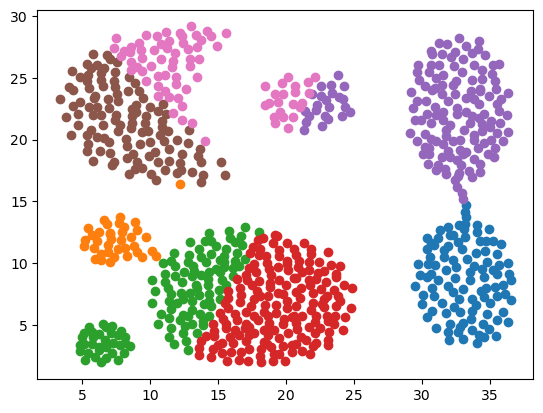

In [15]:
for i in range(7):
    x = Aggregation[best_cluster_labels == i][:,0]
    y = Aggregation[best_cluster_labels == i][:,1]
    plt.scatter(x, y)

plt.show()

In [20]:
#We run 10 kmeans and find the best one with respect to purity
start = time.time()

best_centers , best_cluster_labels = kmeans(Aggregation , 7 , n_iter = 100)

for _ in range(9):
    centers , cluster_labels = kmeans(Aggregation , 7 , n_iter = 100)
    best_purity = purity(Y_Aggregation , best_cluster_labels)

    if best_purity < purity(Y_Aggregation , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels
end = time.time()

print(end - start)

13.299873113632202


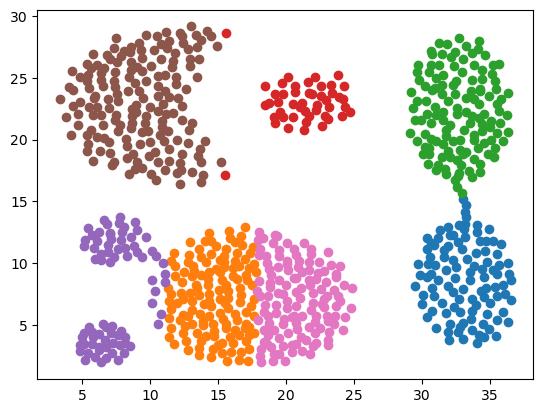

In [21]:
for i in range(7):
    x = Aggregation[best_cluster_labels == i][:,0]
    y = Aggregation[best_cluster_labels == i][:,1]
    plt.scatter(x, y)

plt.show()

حال دیتاست R15 را مورد بررسی قرار میدهیم

In [28]:
Y_R15.value_counts()

2
0     40
1     40
2     40
3     40
4     40
5     40
6     40
7     40
8     40
9     40
10    40
11    40
12    40
13    40
14    40
Name: count, dtype: int64

In [27]:
Y_R15 = Y_R15 - 1

In [32]:
Y_R15.value_counts()

2
0     40
1     40
2     40
3     40
4     40
5     40
6     40
7     40
8     40
9     40
10    40
11    40
12    40
13    40
14    40
Name: count, dtype: int64

k را مساوی 15 قرار میدهیم

In [23]:
#We run 10 kmedians_local_search and find the best one with respect to purity
start = time.time()

best_centers , best_cluster_labels = kmedians_local_search(R15 , k = 15 , n_iter = 3)

for _ in range(9):
    centers , cluster_labels = kmedians_local_search(R15 , k = 15 , n_iter = 3)
    best_purity = purity(Y_R15 , best_cluster_labels)

    if best_purity < purity(Y_R15 , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels
end = time.time()

print(end - start)

448.70934009552


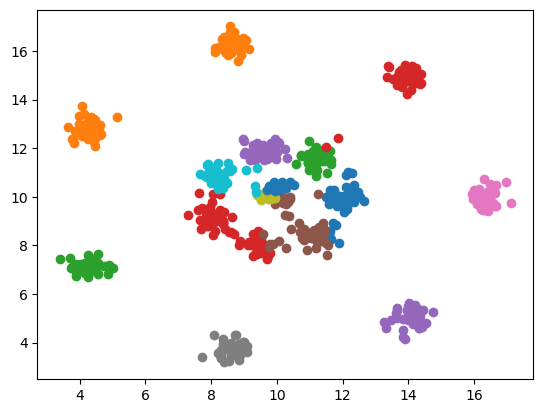

In [24]:
for i in range(15):
    x = R15[best_cluster_labels == i][:,0]
    y = R15[best_cluster_labels == i][:,1]
    plt.scatter(x, y)

plt.show()

In [30]:
#We run 10 kmeans and find the best one with respect to purity
start = time.time()

best_centers , best_cluster_labels = kmeans(R15 , 15 , n_iter = 100)

for _ in range(9):
    centers , cluster_labels = kmeans(R15 , 15 , n_iter = 100)
    best_purity = purity(Y_R15 , best_cluster_labels)

    if best_purity < purity(Y_R15 , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels

end = time.time()

print(end - start)

10.77907943725586


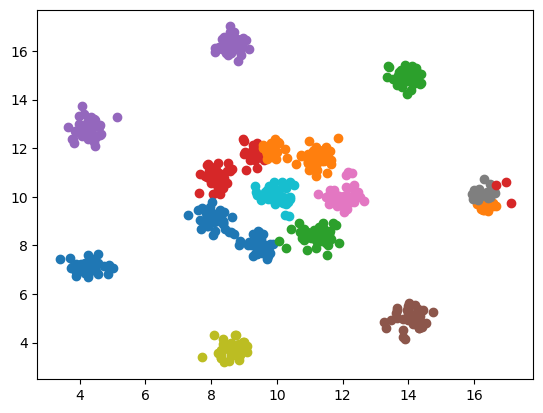

In [31]:
for i in range(15):
    x = R15[best_cluster_labels == i][:,0]
    y = R15[best_cluster_labels == i][:,1]
    plt.scatter(x, y)

plt.show()

حال دیتاست iris را مورد بررسی قرار میدهیم

In [58]:
Y_iris.value_counts()

4
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [59]:
Y_iris.replace('Iris-setosa' , 0 , inplace = True)
Y_iris.replace('Iris-versicolor' , 1 , inplace = True)
Y_iris.replace('Iris-virginica' , 2 , inplace = True)

C:\Users\Atena.Mhz\AppData\Local\Temp\ipykernel_14752\4156656928.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_iris.replace('Iris-virginica' , 2 , inplace = True)


In [60]:
Y_iris.value_counts()

4
0    50
1    50
2    50
Name: count, dtype: int64

In [61]:
iris.shape

(150, 4)

In [63]:
#We run 10 kmedians_local_search and find the best one with respect to purity

start = time.time()


best_centers , best_cluster_labels = kmedians_local_search(iris , k = 3 , n_iter = 3)

for _ in range(9):
    centers , cluster_labels = kmedians_local_search(iris , k = 3 , n_iter = 3)
    best_purity = purity(Y_iris , best_cluster_labels)

    if best_purity < purity(Y_iris , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels
end = time.time()

print(end - start)

10.26008653640747


In [64]:
#We run 10 kmeans and find the best one with respect to purity

start = time.time()

best_centers , best_cluster_labels = kmeans(iris , 3 , n_iter = 100)

for _ in range(9):
    centers , cluster_labels = kmeans(iris , 3 , n_iter = 100)
    best_purity = purity(Y_iris , best_cluster_labels)

    if best_purity < purity(Y_iris , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels
end = time.time()

print(end - start)


6.710087776184082


حال دیتاست glass را بررسی می کنیم.

In [65]:
Y_glass.value_counts()

10
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

In [66]:
#We run 10 kmedians_local_search and find the best one with respect to purity

start = time.time()


best_centers , best_cluster_labels = kmedians_local_search(glass , k = 6 , n_iter = 3)

for _ in range(9):
    centers , cluster_labels = kmedians_local_search(glass , k = 6 , n_iter = 3)
    best_purity = purity(Y_glass , best_cluster_labels)

    if best_purity < purity(Y_glass , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels

end = time.time()

print(end - start)

30.153000116348267


In [71]:
#We run 10 kmeans and find the best one with respect to purity

start = time.time()


best_centers , best_cluster_labels = kmeans(glass , 6 , n_iter = 100)

for _ in range(9):
    centers , cluster_labels = kmeans(glass , 6 , n_iter = 100)
    best_purity = purity(Y_glass , best_cluster_labels)

    if best_purity < purity(Y_glass , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels
end = time.time()

print(end - start)

9.675002098083496


حال دیتاست D31 را مورد بررسی قرار میدهیم

In [64]:
Y_D31.value_counts()

2
1     100
17    100
30    100
29    100
28    100
27    100
26    100
25    100
24    100
23    100
22    100
21    100
20    100
19    100
18    100
16    100
2     100
15    100
14    100
13    100
12    100
11    100
10    100
9     100
8     100
7     100
6     100
5     100
4     100
3     100
31    100
Name: count, dtype: int64

In [ ]:
#We run 10 kmedians_local_search and find the best one with respect to purity
#it is takes a lot of time even for one iteration so it didnt finished all of the ten tries
# I used one of them for visualization

start = time.time()


best_centers , best_cluster_labels = kmedians_local_search(D31 , k = 31 , n_iter = 1)

for _ in range(9):
    centers , cluster_labels = kmedians_local_search(D31 , k = 31 , n_iter = 1)
    best_purity = purity(Y_D31 , best_cluster_labels)

    if best_purity < purity(Y_D31 , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels

end = time.time()

print(end - start)

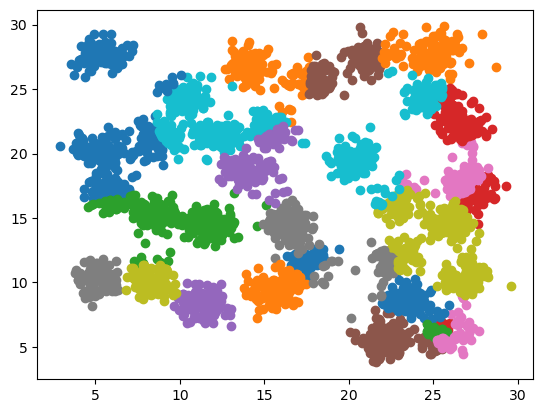

In [73]:
for i in range(31):
    x = D31[best_cluster_labels == i][:,0]
    y = D31[best_cluster_labels == i][:,1]
    plt.scatter(x, y)

plt.show()

In [76]:
#We run 10 kmeans and find the best one with respect to purity

start = time.time()

best_centers , best_cluster_labels = kmeans(D31 , 31 , n_iter = 100)

for _ in range(9):
    centers , cluster_labels = kmeans(D31 , 31 , n_iter = 100)
    best_purity = purity(Y_D31 , best_cluster_labels)

    if best_purity < purity(Y_D31 , cluster_labels):
        best_centers =  centers
        best_cluster_labels = cluster_labels
        
end = time.time()

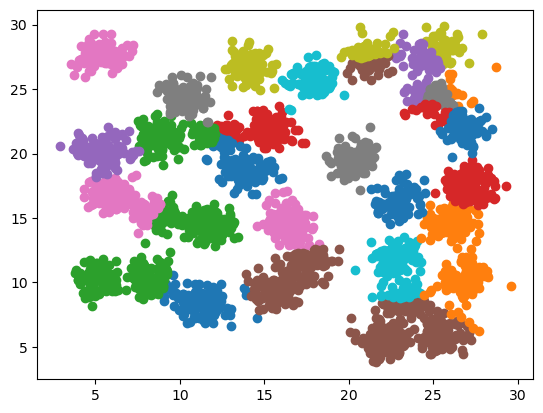

In [77]:
for i in range(31):
    x = D31[best_cluster_labels == i][:,0]
    y = D31[best_cluster_labels == i][:,1]
    plt.scatter(x, y)

plt.show()

مشخصات سیستم در زیر نمایش داده شده است
و زیر هر سلول زمان مورد نیاز جهت راه اندازی آن نوشته شده است..

![alt text](<مشخصات سیستم.PNG>)